Creating window glfw


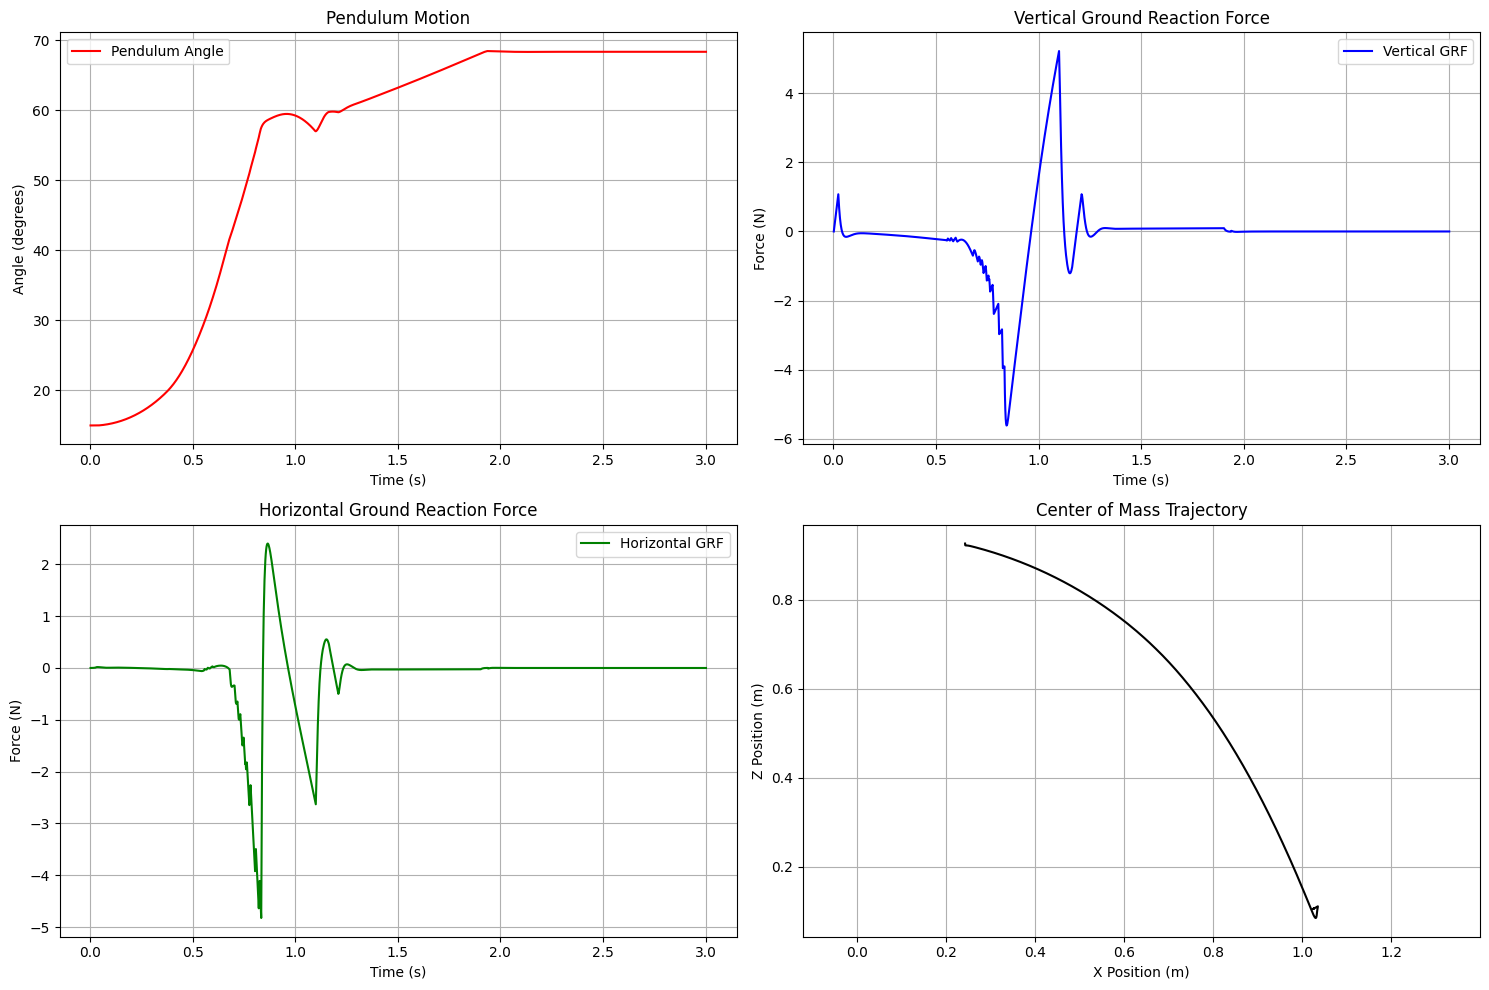

In [4]:
import mujoco_py as mujoco
import numpy as np

def create_humanlike_inverted_pendulum():
    model_xml = """
    <mujoco>
        <option timestep="0.002" gravity="0 0 -9.81">
            <flag sensornoise="enable"/>
        </option>
        
        <asset>
            <material name="grid" rgba=".5 .5 .5 1"/>
            <material name="body" rgba="0.7 0.3 0.3 1"/>
            <texture type="2d" name="groundplane" builtin="checker" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3" width="100" height="100"/>
            <material name="groundplane" texture="groundplane" texrepeat="10 10"/>
        </asset>
        
        <default>
            <geom condim="3" friction="1.0 0.005 0.001"/>
            <joint damping="5.0"/>
        </default>

        <worldbody>
            <!-- Ground plane with visible grid -->
            <geom type="plane" size="10 10 0.1" pos="0 0 0" 
                  solimp="0.9 0.95 0.001" 
                  solref="0.02 1"
                  material="groundplane"
                  name="ground"/>
            
            <!-- Reference grid -->
            <site name="origin" pos="0 0 0" size="0.01"/>
            <geom type="cylinder" fromto="-10 0 0 10 0 0" size="0.01" rgba="1 0 0 0.3"/>
            <geom type="cylinder" fromto="0 -10 0 0 10 0" size="0.01" rgba="0 1 0 0.3"/>
            
           
            <!-- Base (foot) -->
            <body pos="0 0 0.02" name="foot">
                <joint type="free"/>
                <!-- Heel part -->
                <geom type="capsule" fromto="-0.07 0 0.02 -0.03 0 0.02" size="0.025" mass="0.2"
                      material="body"
                      solimp="0.9 0.95 0.001" 
                      solref="0.02 1"/>
                <!-- Mid foot -->
                <geom type="capsule" fromto="-0.03 0 0.02 0.03 0 0.02" size="0.025" mass="0.4"
                      material="body"
                      solimp="0.9 0.95 0.001" 
                      solref="0.02 1"/>
                <!-- Toe part -->
                <geom type="capsule" fromto="0.03 0 0.02 0.08 0 0.015" size="0.02" mass="0.4"
                      material="body"
                      solimp="0.9 0.95 0.001" 
                      solref="0.02 1"/>
                <site name="foot_sensor" pos="0 0 0"/>
            
                <!-- Pendulum rod (representing leg + torso) -->
                <body pos="0 0 0" name="pendulum">
                    <joint name="pin" type="hinge" axis="0 1 0" pos="0 0 0" range="-60 60"/>
                    <geom type="cylinder" fromto="0 0 0 0 0 1.0" size="0.03" mass="5"
                          material="body"/>
                    <!-- Mass at top (representing upper body mass) -->
                    <geom type="sphere" pos="0 0 1.0" size="0.1" mass="50"
                          material="body"/>
                </body>
            </body>
        </worldbody>

        <sensor>
            <force name="grf_sensor" site="foot_sensor"/>
        </sensor>

        <actuator>
            <motor joint="pin" gear="100" name="torque"/>
        </actuator>
    </mujoco>
    """
    
    model = mujoco.load_model_from_xml(model_xml)
    sim = mujoco.MjSim(model)
    viewer = mujoco.MjViewer(sim)
    
    return model, sim, viewer

def simulate_inverted_pendulum(model, sim, viewer, duration=3.0):
    times = []
    angles = []
    forces = []
    com_positions = []
    
    # Set initial conditions
    initial_angle = np.pi/12  # 15 degrees from vertical
    sim.data.qpos[-1] = initial_angle
    sim.data.qvel[-1] = 0
    
    while sim.data.time < duration:
        # Optional: Add control here if needed
        # sim.data.ctrl[0] = control_signal
        
        sim.step()
        viewer.render()
        
        # Record data
        times.append(sim.data.time)
        angles.append(sim.data.qpos[-1])
        forces.append(sim.data.sensordata[0:3].copy())
        
        # Calculate and record COM position
        com_pos = sim.data.subtree_com[1].copy()  # COM of the entire pendulum
        com_positions.append(com_pos)
    
    return (np.array(times), np.array(angles), 
            np.array(forces), np.array(com_positions))

def plot_results(times, angles, forces, com_positions):
    import matplotlib.pyplot as plt
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot pendulum angle
    ax1.plot(times, np.degrees(angles), 'r-', label='Pendulum Angle')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Angle (degrees)')
    ax1.set_title('Pendulum Motion')
    ax1.legend()
    ax1.grid(True)
    
    # Plot vertical GRF
    ax2.plot(times, forces[:, 2], 'b-', label='Vertical GRF')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Force (N)')
    ax2.set_title('Vertical Ground Reaction Force')
    ax2.legend()
    ax2.grid(True)
    
    # Plot horizontal GRF
    ax3.plot(times, forces[:, 0], 'g-', label='Horizontal GRF')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Force (N)')
    ax3.set_title('Horizontal Ground Reaction Force')
    ax3.legend()
    ax3.grid(True)
    
    # Plot COM trajectory
    ax4.plot(com_positions[:, 0], com_positions[:, 2], 'k-', label='COM Path')
    ax4.set_xlabel('X Position (m)')
    ax4.set_ylabel('Z Position (m)')
    ax4.set_title('Center of Mass Trajectory')
    ax4.grid(True)
    ax4.axis('equal')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    model, sim, viewer = create_humanlike_inverted_pendulum()
    times, angles, forces, com_positions = simulate_inverted_pendulum(model, sim, viewer)
    plot_results(times, angles, forces, com_positions)


Creating window glfw


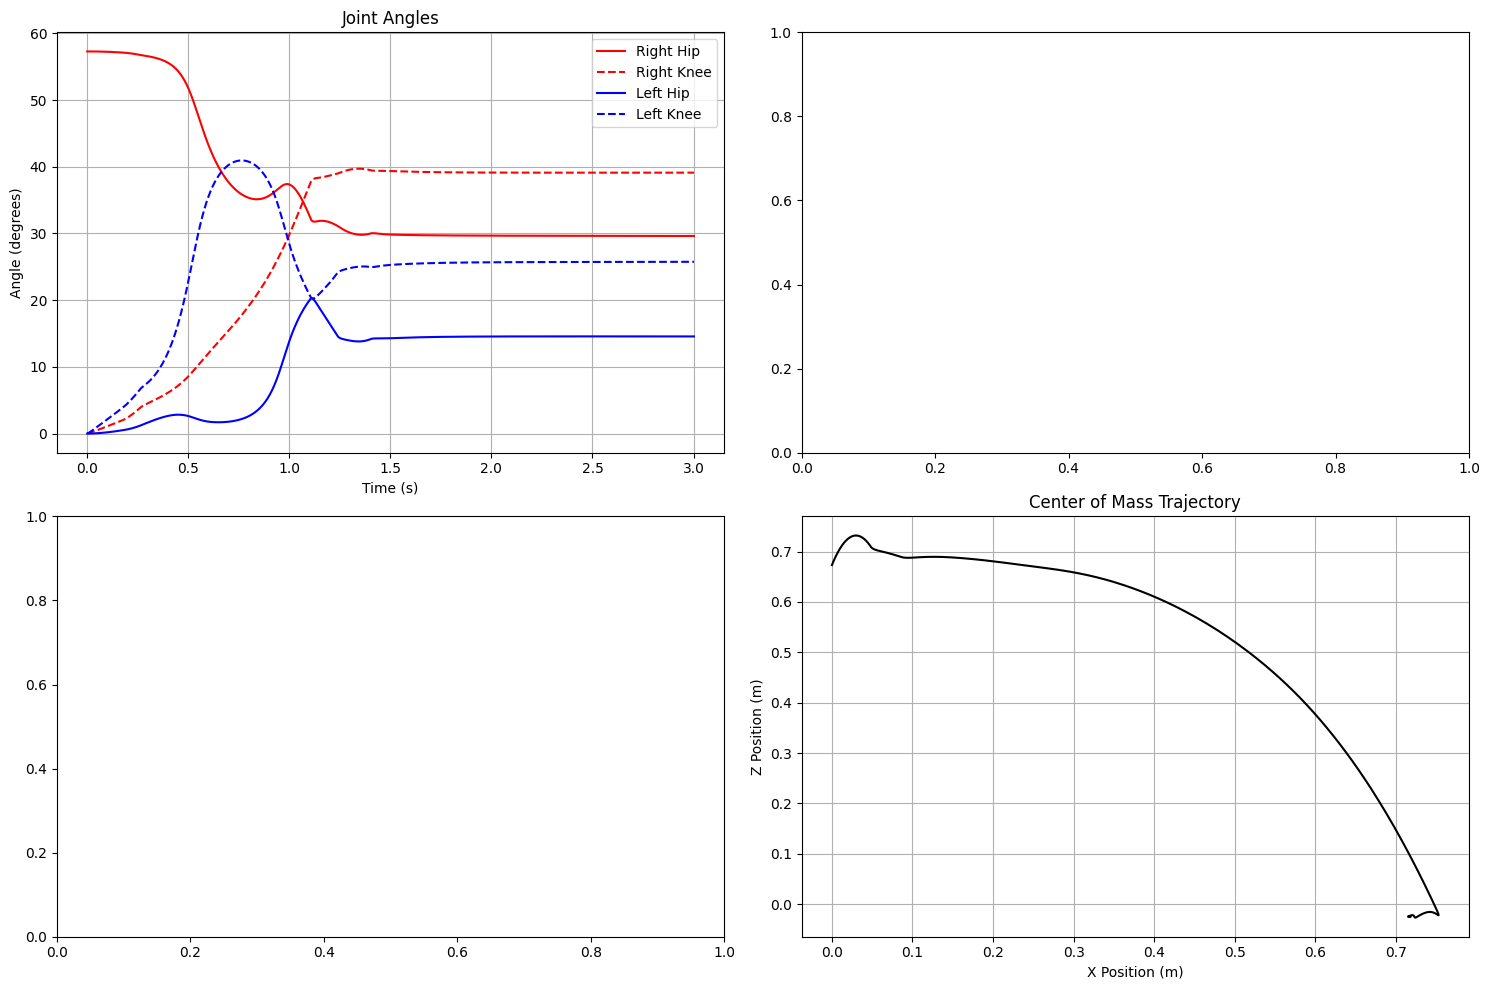

In [ ]:
import mujoco_py as mujoco
import numpy as np

def create_passive_biped_walker():
    model_xml = """
    <mujoco model="passive_walker">
        <option timestep="0.002">
            <flag sensornoise="enable"/>
        </option>
        
        <default>
            <joint limited="true" damping="0.1"/>
            <geom condim="3" friction="1.0 0.005 0.001"/>
        </default>

        <asset>
            <material name="grid" rgba=".5 .5 .5 1"/>
            <material name="body" rgba="0.7 0.3 0.3 1"/>
            <texture type="2d" name="groundplane" builtin="checker" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3" 
                    width="100" height="100"/>
            <material name="groundplane" texture="groundplane" texrepeat="10 10"/>
        </asset>

        <worldbody>
            <!-- Sloped ground -->
            <geom type="plane" size="10 10 0.1" pos="0 0 0" 
                  material="groundplane"
                  euler="0 10 0"/>
            
            <!-- Hip joint (connection point) -->
            <body name="hip" pos="0 0 1.">
                <freejoint/>
                <geom type="sphere" size="0.1" mass="10" material="body"/>
                
                <!-- Right leg -->
                <body name="right_leg" pos="0 0.1 0">
                    <joint name="right_hip" type="hinge" axis="0 1 0" range="-30 30"/>
                    <geom type="capsule" fromto="0 0 0 0 0 -1." size="0.04" mass="10" material="body"/>
                    
                </body>
                
                <!-- Left leg -->
                <body name="left_leg" pos="0 -0.1 0">
                    <joint name="left_hip" type="hinge" axis="0 1 0" range="-30 30"/>
                    <geom type="capsule" fromto="0 0 0 0 0 -1." size="0.04" mass="10" material="body"/>
                </body>
            </body>
        </worldbody>

    
    </mujoco>
    """

    model = mujoco.load_model_from_xml(model_xml)
    sim = mujoco.MjSim(model)
    viewer = mujoco.MjViewer(sim)
    
    return model, sim, viewer

def simulate_passive_walker(model, sim, viewer, duration=3.0):
    times = []
    leg_angles = []
    forces = []
    com_positions = []
    # Set initial conditions


    sim.data.qpos[0:3] = [0, 0, 1.0]  # x, y, z position
    sim.data.qpos[3:7] = [1, 0, 0, 0]  # quaternion orientation
    # Set initial leg angles
    sim.data.qpos[7:] = [0.2, -0.2]  # right and left hip angles
    # Set initial velocities
    sim.data.qvel[5:] = [0, 0.5, -0.5]  # vertical velocity and angular velocities
    while sim.data.time < duration:
        sim.step()
        viewer.render()
        
        # Record data
        times.append(sim.data.time)
        leg_angles.append([
            sim.data.qpos[7],  # right hip
            sim.data.qpos[8],  # left hip
        ])
        # forces.append([
        #     sim.data.sensordata[0:3],  # right GRF
        #     sim.data.sensordata[3:6]   # left GRF
        # ])
        # Calculate and record COM position
        com_pos = sim.data.subtree_com[1].copy()  # COM of the entire pendulum
        com_positions.append(com_pos)
    
    return np.array(times), np.array(leg_angles), np.array(forces), np.array(com_positions)

def plot_walker_results(times, leg_angles, forces, com_positions):
    import matplotlib.pyplot as plt
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot leg angles
    ax1.plot(times, np.degrees(leg_angles[:, 0]), 'r-', label='Right Hip')
    ax1.plot(times, np.degrees(leg_angles[:, 1]), 'r--', label='Left Hip')
    ax1.set_ylabel('Angle (degrees)')
    ax1.set_title('Joint Angles')
    ax1.legend()
    ax1.grid(True)
    
    # # Plot vertical GRF
    # ax2.plot(times, forces[:, 0, 2], 'r-', label='Right Foot')
    # ax2.plot(times, forces[:, 1, 2], 'b-', label='Left Foot')
    # ax2.set_xlabel('Time (s)')
    # ax2.set_ylabel('Vertical Force (N)')
    # ax2.set_title('Ground Reaction Forces')
    # ax2.legend()
    # ax2.grid(True)
    
    # # Plot horizontal GRF
    # ax3.plot(times, forces[:, 0, 0], 'r-', label='Right Foot')
    # ax3.plot(times, forces[:, 1, 0], 'b-', label='Left Foot')
    # ax3.set_xlabel('Time (s)')
    # ax3.set_ylabel('Horizontal Force (N)')
    # ax3.set_title('Horizontal Ground Reaction Forces')
    # ax3.legend()
    # ax3.grid(True)
    
    # plot com trajectory
    ax4.plot(com_positions[:, 0], com_positions[:, 2], 'k-', label='COM Path')
    ax4.set_xlabel('X Position (m)')
    ax4.set_ylabel('Z Position (m)')
    ax4.set_title('Center of Mass Trajectory')
    ax4.grid(True)  
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    model, sim, viewer = create_passive_biped_walker()
    times, leg_angles, forces, coms = simulate_passive_walker(model, sim, viewer)
    plot_walker_results(times, leg_angles, forces, coms)


In [ ]:

import os
os.environ['MUJOCO_GL'] = 'glfw'
import glfw

# Add these lines before creating the physics environment
glfw.init()
glfw.window_hint(glfw.CONTEXT_VERSION_MAJOR, 1)
glfw.window_hint(glfw.CONTEXT_VERSION_MINOR, 5)
glfw.window_hint(glfw.CONTEXT_CREATION_API, glfw.NATIVE_CONTEXT_API)


# Make sure no dm_control imports happened before this point
# Remove any previous imports of dm_control if they exist
import sys
if 'dm_control' in sys.modules:
    del sys.modules['dm_control']


from dm_control import mujoco
from dm_control import viewer
import numpy as np
import matplotlib.pyplot as plt

def create_walker():
    model_xml = """
    <mujoco model="passive_walker">
        <option timestep="0.002"/>
        
        <default>
            <joint damping="0.1"/>
            <geom condim="3" friction="1.0 0.005 0.001"/>
        </default>

        <worldbody>
            <!-- Sloped ground -->
            <geom type="plane" size="10 10 0.1" pos="0 0 0" euler="0.05 0 0"/>
            
            <!-- Walker body -->
            <body name="hip" pos="0 0 1.7">
                <freejoint/>
                <geom type="sphere" size="0.1" mass="10"/>
                
                <!-- Legs -->
                <body name="right_leg" pos="0 0.1 0">
                    <joint name="right_hip" type="hinge" axis="0 1 0" range="-30 30"/>
                    <geom type="capsule" fromto="0 0 0 0 0 -0.85" size="0.03" mass="5"/>
                    <body name="right_shin" pos="0 0 -0.85">
                        <joint name="right_knee" type="hinge" axis="0 1 0" range="0 70"/>
                        <geom type="capsule" fromto="0 0 0 0 0 -0.85" size="0.03" mass="5"/>
                        <site name="right_foot" pos="0 0 -0.85"/>
                    </body>
                </body>
                
                <body name="left_leg" pos="0 -0.1 0">
                    <joint name="left_hip" type="hinge" axis="0 1 0" range="-30 30"/>
                    <geom type="capsule" fromto="0 0 0 0 0 -0.85" size="0.03" mass="5"/>
                    <body name="left_shin" pos="0 0 -0.85">
                        <joint name="left_knee" type="hinge" axis="0 1 0" range="0 70"/>
                        <geom type="capsule" fromto="0 0 0 0 0 -0.85" size="0.03" mass="5"/>
                        <site name="left_foot" pos="0 0 -0.85"/>
                    </body>
                </body>
            </body>
        </worldbody>

        <sensor>
            <force name="right_grf" site="right_foot"/>
            <force name="left_grf" site="left_foot"/>
        </sensor>
    </mujoco>
    """
    physics = mujoco.Physics.from_xml_string(model_xml)
    return physics

def simulate(physics, duration=10.0):
    # Set initial conditions
    with physics.reset_context():
        physics.data.qpos[7:] = [0.1, -0.1, 0.2, 0]
        physics.data.qvel[6:] = [0.1, -0.1, 0, 0]
    
    # Create viewer
    return viewer.launch(physics)

def plot_data(physics):
    # Record 500 steps of data
    steps = 500
    angles = np.zeros((steps, 4))
    forces = np.zeros((steps, 2, 3))
    
    for i in range(steps):
        physics.step()
        angles[i] = physics.data.qpos[3:7]
        forces[i] = physics.data.sensordata.reshape(2, 3)
    
    times = np.linspace(0, steps * physics.timestep, steps)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(times, np.degrees(angles))
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Joint Angles (degrees)')
    ax1.legend(['Right Hip', 'Right Knee', 'Left Hip', 'Left Knee'])
    
    ax2.plot(times, forces[:, :, 2])
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Vertical GRF (N)')
    ax2.legend(['Right Foot', 'Left Foot'])
    
    plt.show()

if __name__ == "__main__":
    physics = create_walker()
    simulate(physics)
    plot_data(physics)


Error: Attempt to retrieve context when no valid context